In [54]:
%matplotlib inline
import numpy as np
import healpy as hp
import pandas as pd
import scipy.constants as const
from astropy.io import fits
from astropy.cosmology import WMAP5
from astropy import units as u
from astropy.coordinates import SkyCoord

In [55]:
# User Inputs

#theta, phi, ul, ul_err = np.loadtxt('11yr_skymap_v4.txt', skiprows=1, unpack=True, usecols=(1,2,3,4))
data = np.genfromtxt('11yr_skymap_v4.txt', names=True)
#print(data['ul'])

# TODO: Put unit conversion for latitude
input_theta = .35
input_phi = 4.2

input_long = "43°2’27”"
input_lat = 40



In [56]:
orbital_s = 10.
orbital_p = 400.

# These unit conversions by no means need to be functions, just did so to make it clear for now
def yrs_to_s(years):
    return years*365*24*3600
def pc_to_m(pc):
    return pc*3.0856776e16
def kg_to_M0(kg):
    return kg/1.98847e30
def M0_to_kg(M0):
    return M0*1.98847e30
def m_to_pc(m):
    return m/30856776e9
def s_to_yrs(s):
    return s/(365*24*3600)

In [57]:
def totalmasscalc(orbital_s, orbital_p): 
    return kg_to_M0((4*(const.pi**2)*(pc_to_m(orbital_s/2))**3)/(const.G * (yrs_to_s(orbital_p))**2))

print("{:.3e}".format(totalmasscalc(10, 400)))

6.866e+12


In [58]:
def orbitalsepcalc(total_m, orbital_p):
    return 2*np.cbrt((const.G * M0_to_kg(total_m) * yrs_to_s(orbital_p)**2)/(4*(const.pi)**2))
print("{:.2f}".format(m_to_pc(orbitalsepcalc(6.865588e+12, 400))))

10.00


In [59]:
def orbitalpercalc(total_m, orbital_s):
    return s_to_yrs(np.sqrt((4 * (const.pi**2) * (pc_to_m(orbital_s)/2)**3)/(const.G * M0_to_kg(total_m))))
print("{:.2f}".format(orbitalpercalc(6.865588e+12, 10)))

400.00


In [60]:
#TODO: Either use astropy or manual linear approximation. Eventually would like to implement full expansion
# For astropy don't forget to strip units and convert to float
distance = .0237
def distancecalc(redshift):
    return (WMAP5.comoving_distance(redshift))
print("{:.2f}".format(distancecalc(.0237)))

100.71 Mpc


In [61]:
# TODO: This is the linear approximation I was talking about. Both will likely change slightly
# Ok so this answer seems really wrong, but actually that's just cuz it turns out this linear approximation is just really bad at long AND short distances. Will be fixed with full expansion.
def redshiftcalc(distance):
    H0 = 70
    return (distance*H0)/(const.c*1e-3)
print(const.c*1e-3)
print(redshiftcalc(100.7105))
print(round(float(redshiftcalc(100.71)), 5))

299792.458
0.023515384766617443
0.02352


In [62]:
# TODO: Haven't done these units yet
def gwave_strain(total_m, orbital_p, distance):
    return 190 * (((total_m)/10e9)**(5./3.)) * ((orbital_p)**(1./3.)) * (100/distance)
print(gwave_strain(1e9, 1, 100))

4.093425911060579


In [63]:
#c1 = fits.Column(name='theta', array= theta, format=('D'))
#c2 = fits.Column(name='phi', array= phi, format=('D'))
#c3 = fits.Column(name='ul', array= ul, format=('D'))
#c4 = fits.Column(name='ul_err', array= ul_err, format=('D'))
#t = fits.BinTableHDU.from_columns([c1, c2, c3, c4])
#t.writeto('ul.fits', overwrite=True)
#skymap = hp.fitsfunc.mrdfits(t)
#hp.mollview(skymap, title= 'Upper Limit Skymap')


In [64]:
#x = radius * cos(latitude) * cos(longitude)
#y = radius * cos(latitude) * sin(longitude)
#z = radius * sin(latitude)

In [65]:
ul1 = data['ul']
ul2 = data['ul']*.5
ul3 = data['ul']*.08
ul4 = data['ul']*1.3

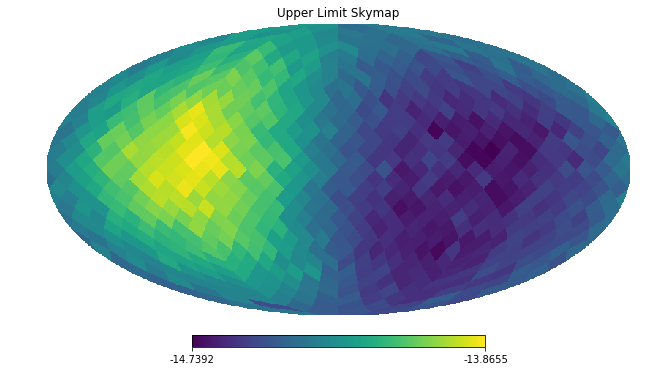

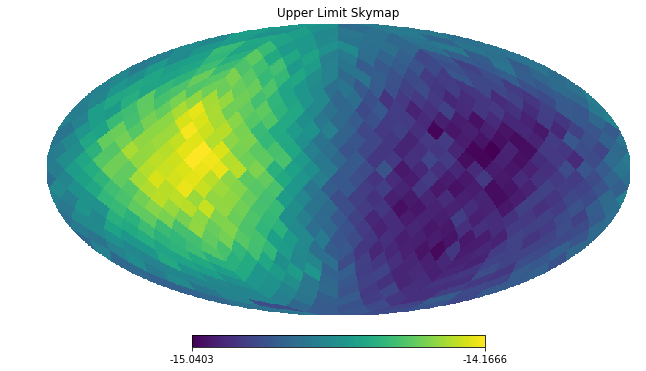

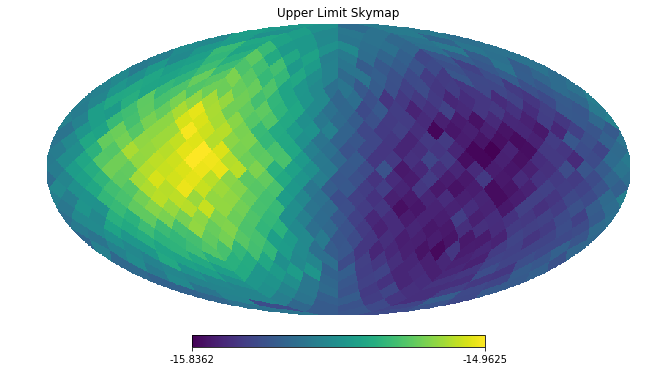

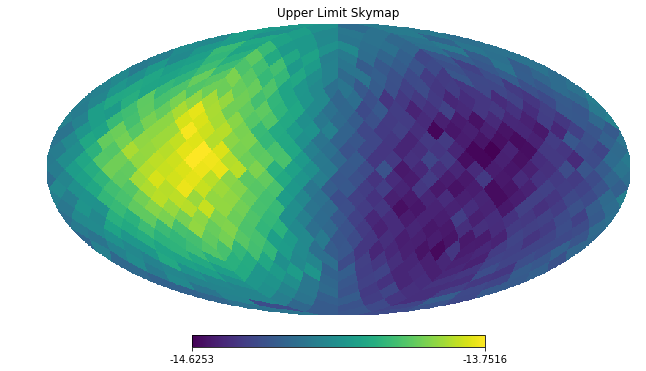

In [66]:
def find_ul(skymap, theta, phi):
    return hp.pixelfunc.get_interp_val(skymap, theta, phi)

def create_map(theta, phi, ul): 
    nside = 8
    npix = hp.nside2npix(nside)
    indices = hp.ang2pix(nside, theta, phi)
    skymap = np.zeros(npix, dtype=np.float)
    skymap[indices] += ul[indices]
    hp.mollview(np.log10(skymap), title= 'Upper Limit Skymap')
    return skymap
skymap1 = create_map(data['theta'], data['phi'], ul1)
skymap2 = create_map(data['theta'], data['phi'], ul2)
skymap3 = create_map(data['theta'], data['phi'], ul3)
skymap4 = create_map(data['theta'], data['phi'], ul4)

In [67]:
input_freq = 3e-9

freq_ul_array = []

freq_array = np.array([find_ul(skymap1, input_theta, input_phi), find_ul(skymap2, input_theta, input_phi)])
print(freq_array)
sig_array = np.array([find_ul(skymap3, input_theta, input_phi), find_ul(skymap4, input_theta, input_phi)])
print(sig_array)

[3.86392134e-15 1.93196067e-15]
[3.09113707e-16 5.02309774e-15]


In [68]:
min_location = np.where(data['ul'] == data['ul'].min())[0]
theta_min, phi_min = hp.pix2ang(nside, min_location)

max_location = np.where(data['ul'] == data['ul'].max())[0]
theta_max, phi_max = hp.pix2ang(nside, max_location)

NameError: name 'nside' is not defined

In [ ]:
# TODO: Maybe figure out plotting stuff so that I can put a marker on the skymap based on the input theta and phi. Easy part is I know exactly how to find that pixel now, hard part is plotting these is ridiculous.
#def find_ul(skymap, theta, phi):
#    return hp.pixelfunc.get_interp_val(skymap, theta, phi)

#print("The interpolated gravitational wave strain for theta = {0:.3f}, phi = {1:.3f} is: {2:.3e}".format(input_theta, input_phi, find_ul(input_theta, input_phi)))
#print("For Context: ")
#print('Least sensitive sky location is at theta = {0:.3f}, phi = {1:.3f}, with a value of {2:.3e}'.format(float(theta_max), float(phi_max), float(data['ul'][min_location])))
#print('Most sensitive sky location:  theta_min = {0:.3f}, phi_min = {1:.3f}, with a value of {2:.3e}'.format(float(theta_min), float(phi_min), float(data['ul'][max_location])))


In [ ]:
theta = '30.40'
hours, minutes = theta.split('.')
position_ra = '20h14m00.01s'

In [ ]:
RA_hours = position_ra.replace('h',',').replace('m', ',').replace('s', ',').split(',')

In [ ]:
theta = float(RA_hours[0]) + float(RA_hours[1])/60 + float(RA_hours[2])/3600

In [ ]:
print(theta)

In [ ]:
dec_hours = '+{0}d{1}m'.format(hours, minutes)
print(dec_hours)

In [ ]:
a = SkyCoord(position_ra, dec_hours, frame='icrs')
print(a.ra.degree)  

In [ ]:
mass = 1e9
DL = 100
zeta = mass**(5/3)/DL

a(n) = n * zeta * (2*pi*freq)**(2/3) * np.Cos(n*l(t))

J(n-2, ne - 2*e*j)

In [ ]:
def s_plus(xa, xb):
    return 7/15(xa(n)**2 + xb(n)**2) + 4/15*xc(n)**2
test = s_plus()

In [ ]:
import scipy.special as spec
import matplotlib.pyplot as plt

In [ ]:
n = np.arange(10)
x = np.arange(10)
J0 = lambda x: spec.jn(n, x)

plt.plot(x, J0(x))
plt.show()